In [121]:
#pip install yahoofinancials # if package is not installed, please uncomment to install
#pip install numpy_financial

import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as st
from scipy.optimize import minimize
from sklearn.linear_model import LinearRegression
import datetime
from dateutil.relativedelta import *
import matplotlib.pyplot as plt
from yahoofinancials import YahooFinancials
import numpy_financial as npf


In [2]:
report_date = '2021-06-01'

In [36]:
# select asset, time period, frequancy 

# run this for USD Portfolio
assets = ['SPY','QQQ','VWO','EWC','EFA','VGK','IOO','SHY','IEF','TIP','IYR']
inqu = ['^IRX','CADUSD=X']+assets
yahoo_financials = YahooFinancials(inqu)
data = yahoo_financials.get_historical_price_data(start_date='2006-04-01', 
                                                  end_date='2021-06-02', 
                                                  time_interval='monthly')

In [51]:
# run this for CAD Portfolio

assets = ['XSP.TO','XIU.TO','XIN.TO','XBB.TO','XGB.TO','XRB.TO','XRE.TO']
inqu = ['^IRX','CADUSD=X']+assets
yahoo_financials = YahooFinancials(inqu)
data = yahoo_financials.get_historical_price_data(start_date='2006-04-01', 
                                                  end_date='2021-06-02', 
                                                  time_interval='monthly')
                                                  

In [6]:
# defined functions

# processing formatt

def dataSlicing(df1,df2,df3,df4):

    
    #need to transfer to main code
    
    asset_1_num = df1.shape[1]
    asset_2_num = df2.shape[1]
    asset_3_num = df3.shape[1]
    asset_4_num = df4.shape[1]
    
    asset_1_index = list(range(0 , asset_1_num))
    asset_2_index = list(range(asset_1_num , asset_1_num+asset_2_num))
    asset_3_index = list(range(asset_1_num+asset_2_num , asset_1_num+asset_2_num+asset_3_num))
    asset_4_index = list(range(asset_1_num+asset_2_num+asset_3_num ,asset_1_num+asset_2_num+asset_3_num+asset_4_num))
        
    total_df = pd.concat([df1,df2,df3,df4], axis=1)# merge the 4 asset class
    ticker = list(total_df)        #[1:]#the first is the time stamp
    #print(total_df.shape[1]) # get the amount of columns of the dataframe
    
    return total_df,ticker

def formDf(x,ticker):
    x = pd.DataFrame(x).T
    x.columns = ticker
    return x

In [7]:
# Strategies

# Equal Weight 

def EW(df1,df2,df3,df4):
    
    total_df,ticker = dataSlicing(df1,df2,df3,df4)
    Q = total_df.cov()
    numAsset = total_df.shape[1]
    
    weight_eq = pd.DataFrame(np.repeat(1/numAsset, numAsset))
    x_ew = formDf(weight_eq,ticker) # result for equal weight
    return x_ew

In [8]:
# Minimum Variance optimization Block

def minVarianceOpt(numAsset, Q):
    def objective(weight):#weight
        weight = np.array(weight)
        return weight.dot(Q).dot(weight.T)

    #constraints
    cons = ({'type':"eq",'fun':lambda x: np.sum(x)-1},
           )

    #long only
    bounds = tuple((0,1) for x in range(numAsset))

    #initialize the weights with an even split, equal weights
    guess = pd.DataFrame(np.repeat(1/numAsset, numAsset))
    optimized_result = minimize(objective, guess, method = "SLSQP", bounds  = bounds, constraints= cons)

    return optimized_result

def MV(df1,df2,df3,df4):
    total_df, ticker = dataSlicing(df1,df2,df3,df4)
    Q = total_df.cov()
    numAsset = total_df.shape[1]

    x_mv = minVarianceOpt(numAsset,Q).x
    x_mv = formDf(x_mv,ticker)
    return x_mv

In [35]:
# All Weather Block

def minVarianceOpt_allWeather(numAsset,Q, asset_1_index, asset_2_index, asset_3_index, asset_4_index):
    def objective(weight):#weight
        weight = np.array(weight)
        return weight.dot(Q).dot(weight.T)

    #constraints
    cons = ({'type':"eq",'fun':lambda x: np.sum(x)-1},
            {"type":"ineq",'fun': lambda x: np.sum(np.array(x)[asset_1_index])-0.15 },
            {"type":"ineq",'fun': lambda x: np.sum(np.array(x)[asset_2_index])-0.15 },
            {"type":"ineq",'fun': lambda x: np.sum(np.array(x)[asset_3_index])-0.15 },
            {"type":"ineq",'fun': lambda x: np.sum(np.array(x)[asset_4_index])-0.15 },
            {"type":"ineq",'fun': lambda x: 0.30-np.sum(np.array(x)[asset_1_index]) },
            {"type":"ineq",'fun': lambda x: 0.30-np.sum(np.array(x)[asset_2_index]) },
            {"type":"ineq",'fun': lambda x: 0.30-np.sum(np.array(x)[asset_3_index]) },
            {"type":"ineq",'fun': lambda x: 0.30-np.sum(np.array(x)[asset_4_index]) },
           )

    #long only
    bounds = tuple((0,0.3) for x in range(numAsset))

    #initialize the weights with an even split, equal weights
    guess = pd.DataFrame(np.repeat(1/numAsset, numAsset))
    optimized_result = minimize(objective, guess, method = "SLSQP", bounds  = bounds, constraints= cons)

    return optimized_result

def AW(df1,df2,df3,df4):
    
    asset_1_num = df1.shape[1]
    asset_2_num = df2.shape[1]
    asset_3_num = df3.shape[1]
    asset_4_num = df4.shape[1]
    
    asset_1_index = list(range(0 , asset_1_num))
    asset_2_index = list(range(asset_1_num , asset_1_num+asset_2_num))
    asset_3_index = list(range(asset_1_num+asset_2_num , asset_1_num+asset_2_num+asset_3_num))
    asset_4_index = list(range(asset_1_num+asset_2_num+asset_3_num ,asset_1_num+asset_2_num+asset_3_num+asset_4_num))
    
    total_df, ticker = dataSlicing(df1,df2,df3,df4)
    Q = total_df.cov()
    numAsset = total_df.shape[1]
    
    x_mvo_allWeather = minVarianceOpt_allWeather(numAsset,Q, asset_1_index,asset_2_index,asset_3_index,asset_4_index).x
    x_mvo_allWeather = formDf(x_mvo_allWeather, ticker)
    return x_mvo_allWeather

In [10]:
# Naive Risk Parity Block

def NR(df1,df2,df3,df4):
    total_df, ticker = dataSlicing(df1,df2,df3,df4)
    Q = total_df.cov()
    numAsset = total_df.shape[1]
    
    sigma_sq = np.diagonal(Q)# variance for all assets (sigma^2 )
    #1/sigma^2
    inv_sigma_sq = pd.DataFrame(sigma_sq).rdiv(1).T 

    # 1/sigma
    inv_sigma = inv_sigma_sq.apply(np.sqrt)
    inv_sigma= np.array(inv_sigma.iloc[0,:].tolist())
    
    x_naive_rp = []
    denom = np.sum(inv_sigma) #sum of 1/sigma at the denominator

    for i in range(numAsset):
        x_naive_rp.append((inv_sigma[i]/denom))

    x_naive_rp = formDf(x_naive_rp, ticker)
    return x_naive_rp

In [11]:
# Risk Parity Block

def rp_obj(y, Q):    #objective function for Risk parity
    kappa = 5

    return np.dot(Q,y)-kappa*np.reciprocal(y) #using the gradient of f(y) = 0

def RP(df1,df2,df3,df4):
    total_df, ticker = dataSlicing(df1,df2,df3,df4)
    Q = total_df.cov()
    numAsset = total_df.shape[1]
    guess = pd.DataFrame(np.repeat(1/numAsset, numAsset))
    y = sp.optimize.fsolve(rp_obj, guess, args = Q)

    x_rp=[]
    y_sum = np.sum(y)
    for i in range(len(y)):
        x_rp.append(y[i]/y_sum)
    x_rp = formDf(x_rp, ticker)
    
    return x_rp

In [12]:
# Trend Following
def TF(df1,df2,df3,df4):
    total_df, ticker = dataSlicing(df1,df2,df3,df4)

    numAsset = total_df.shape[1]
    
    Q = total_df.cov()

    sigma_sq = np.diagonal(Q)# variance for all assets (sigma^2 )
    
    ma4 = (total_df.iloc[-4:,:]+1).prod(axis=0).to_list()
    ma1 = ((total_df.iloc[-1:,:]+1).prod(axis=0)**4).to_list()
    
    x = []
    sum_x = 0

    for i in range(numAsset):
        w=(np.exp(ma1[i]-ma4[i]))**2
        x.append(w)
        sum_x = sum_x + w

    x = formDf(x, ticker)
    return x/sum_x

In [13]:
# Trend Reversal
def TR(df1,df2,df3,df4):
    total_df, ticker = dataSlicing(df1,df2,df3,df4)

    numAsset = total_df.shape[1]
    
    Q = total_df.cov()

    sigma_sq = np.diagonal(Q)# variance for all assets (sigma^2 )
    
    ma4 = (total_df.iloc[-4:,:]+1).prod(axis=0).to_list()
    ma1 = ((total_df.iloc[-1:,:]+1).prod(axis=0)**4).to_list()
    
    x = []
    sum_x = 0

    for i in range(numAsset):
        w=(np.exp(ma4[i]-ma1[i]))**2
        x.append(w)
        sum_x = sum_x + w

    x = formDf(x, ticker)
    return x/sum_x

In [20]:
# calibration period back function 
def back_mth(str_date, month_back):
    t=datetime.datetime.strptime(str_date, "%Y-%m-%d").date()
    t=t+ relativedelta(months=-month_back)
    t=t.strftime('%Y-%m-%d')
    return t

In [21]:
# validation start date
incept_date_v = '2011-04-01'

# testing start date
incept_date_t = '2016-04-01'

# rebalance dates
rebal_dates = pd.date_range(start=incept_date_v, end=report_date, freq='2QS')[1:] #['2011-10-01', '2012-04-01', ... ,'2021-04-01']



In [54]:
# managing data

# Portfolio price and return
df['Port_P'] = np.NaN
df['Port_R'] = np.NaN


# dataframes for asset's return, excess return, price, weight, and unit of shares 
df_R = pd.DataFrame(index=df.index)
df_exR = pd.DataFrame(index=df.index)
df_P = pd.DataFrame(index=df.index)
df_W = pd.DataFrame(index=df.index)
df_U = pd.DataFrame(index=df.index)

for asset in assets:
    df_R[asset]=df[asset+'_R']
    df_exR[asset]=df[asset+'_R']-df_rf['Mth_rf']
    df_P[asset]=df[asset+'_P']
    df_W[asset]=np.NaN
    df_U[asset]=np.NaN
    
# dataframes for transaction records and fee
df_trans_rec = pd.DataFrame(columns=assets)
df_trans_fee = pd.DataFrame(columns=assets)    
    
# dataframes for annual return of fiscal year end
df_RR = pd.DataFrame(columns=['Port']+assets)
report_dates = pd.date_range(start=incept_date_v, periods=11, freq='4QS')[0:].strftime('%Y-%m-%d').to_list()+[report_date]

In [39]:
# USD split assets excess return data based on class
df1 = df_exR[['SPY','QQQ','VWO','EWC','EFA','VGK','IOO']]
df2 = df_exR[['SHY','IEF']]
df3 = df_exR[['TIP']]
df4 = df_exR[['IYR']]

In [55]:
# CAD split assets excess return data based on class
df1 = df_exR[['XSP.TO','XIU.TO','XIN.TO','XBB.TO']]
df2 = df_exR[['XGB.TO']]
df3 = df_exR[['XRB.TO']]
df4 = df_exR[['XRE.TO']]

In [56]:
# Try each strategy

# choose time mode for validation or testing v<->t
inc_date = incept_date_t
rb_dates = rebal_dates
eva_date = report_date

# calibration period (max 59 for this example)
Back = 59

# Transaction fee rate
fee_rate = 0.005

# initial Portfolio value
inc_value=100000/2#*df_ex.loc[inc_date,'CAD/USD'] # if needed to convert to USD
df.loc[inc_date,'Port_P'] = inc_value

# injection value (in cad) #set to 0 for vallidation mode
inject_value = 10000/2

# initial asset weights
'''pick strategy function'''
weights = AW(df1.loc[:inc_date,:],df2.loc[:inc_date,:],df3.loc[:inc_date,:],df4.loc[:inc_date,:])

# initial unit of shares to invest
for asset in assets:
    df_W.loc[inc_date,asset] = weights[asset][0]
    df_U.loc[inc_date,asset] = weights[asset][0]*inc_value/df_P.loc[inc_date,asset]
    df_trans_rec.loc[inc_date,asset] = df_U.loc[inc_date,asset]

# Portfolio evaluation
for i in df.index:
    if (i > inc_date) and (i<= eva_date):
        
        df_U.loc[i]= df_U.shift().loc[i]
        df.loc[i,'Port_P'] = df_U.loc[i].dot(df_P.loc[i])
        df.loc[i,'Port_R'] = df.loc[i,'Port_P']/df.shift().loc[i,'Port_P']-1
        df_W.loc[i] = df_U.loc[i]*df_P.loc[i]/df.loc[i,'Port_P']

        if i in rb_dates:
            
            # new asset weights
            '''pick strategy fuction'''
            weights = AW(df1.loc[back_mth(i, Back):i,:],df2.loc[back_mth(i, Back):i,:],df3.loc[back_mth(i, Back):i,:],df4.loc[back_mth(i, Back):i,:])

            # total transaction cost at rebalance date
            trans_cost = 0
            
            # injection if needed
            new_port = df.loc[i,'Port_P']+inject_value#*df_ex.loc[i,'CAD/USD'] # if need to convert to USD
            
            for asset in assets:
                df_W.loc[i,asset] = weights[asset][0]
                new_unit = weights[asset][0]*new_port/df_P.loc[i,asset]
                old_unit = df_U.loc[i,asset]
                df_trans_rec.loc[i,asset] = new_unit - old_unit
                df_trans_fee.loc[i,asset] = abs(new_unit - old_unit)*df_P.loc[i,asset]*fee_rate
                trans_cost = trans_cost + df_trans_fee.loc[i,asset]
                
            df.loc[i,'Port_P'] = new_port-trans_cost
                        
            # new unit of shares
            for asset in assets:
                df_U.loc[i,asset] = weights[asset][0]*df.loc[i,'Port_P']/df_P.loc[i,asset]
                
        # record fiscal year end annual return        
        if i in report_dates:
            if i> inc_date:
            
                for asset in assets:
                    df_RR.loc[i,[asset]] = ((df_R.loc[report_dates[report_dates.index(i)-1]:i,[asset]]+1).prod()-1)[0]

                df_RR.loc[i,['Port']] = ((df.loc[report_dates[report_dates.index(i)-1]:i,['Port_R']]+1).prod()-1)[0]


In [57]:
name='_cad_AW_t.xlsx'

In [58]:
df_U.to_excel('df_U'+name)
df_W.to_excel('df_W'+name)
df_trans_rec.to_excel('df_trans_rec'+name)
df_trans_fee.to_excel('df_trans_fee'+name)

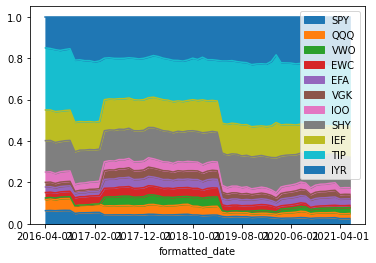

In [66]:
#USD
df_W.loc[inc_date:eva_date,:].plot(kind='area')

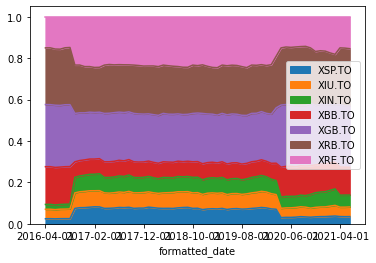

In [81]:
#CAD
df_W.loc[inc_date:eva_date,:].plot(kind='area')

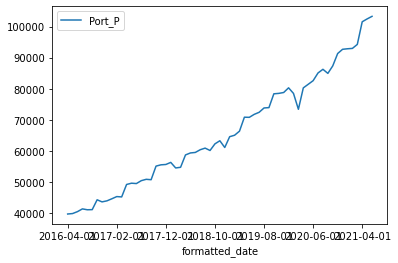

In [67]:
#USD
df.loc[:,['Port_P']].plot()

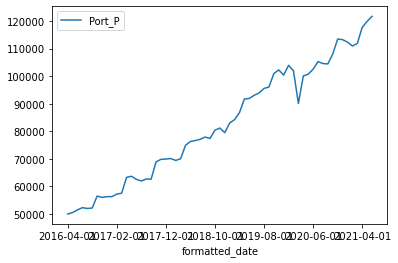

In [82]:
#CAD
df.loc[:,['Port_P']].plot()

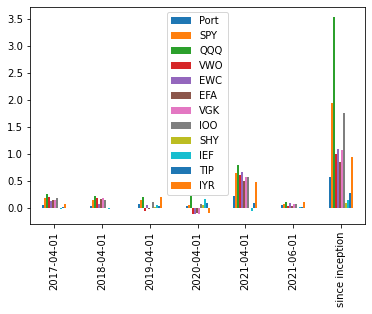

In [68]:
#USD
df_RR.append(pd.Series(name='since inception',data=(df_RR+1).prod()-1)).plot.bar()

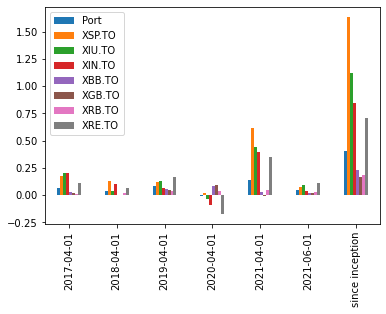

In [83]:
#CAD
df_RR.append(pd.Series(name='since inception',data=(df_RR+1).prod()-1)).plot.bar()

In [120]:
df_trans_fee

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
2016-10-01,14.7158,8.84577,14.9644,25.4351,10.9298,5.42542,28.2644
2017-04-01,0.149997,1.0264,0.114406,2.57959,8.51647,10.4663,2.67561
2017-10-01,0.101789,1.05432,0.18672,2.27799,7.25078,7.8849,6.2435
2018-04-01,1.48914,2.59832,2.22051,2.35369,7.61198,5.47854,3.24782
2018-10-01,1.30522,2.5046,3.46018,2.17681,6.8129,7.76468,0.975629
2019-04-01,1.65577,0.33349,1.81128,2.43447,7.35666,7.56315,3.84518
2019-10-01,2.28865,3.22448,2.44224,2.20769,6.93822,7.61449,0.284237
2020-04-01,20.629,12.3213,5.35911,32.9435,26.012,20.2769,15.923
2020-10-01,0.34889,0.174821,7.67863,1.3951,10.9447,3.50958,8.31705
2021-04-01,1.44455,2.71923,10.856,7.79921,22.3406,27.61,17.73


In [45]:
df_trans_fee

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR
2016-10-01,1.99951,3.81556,1.51105,3.26963,0.846095,1.95712,2.75515,4.74291,1.81391,5.66169,16.0503
2017-04-01,2.07546,1.22257,10.35,1.66126,5.53009,7.7781,2.12775,1.93514,6.25636,16.7514,0.28634
2017-10-01,0.294396,0.0627972,0.0681586,0.165859,0.124808,0.0863625,0.055426,4.41403,4.24426,5.80331,4.43676
2018-04-01,0.325342,0.0346122,0.397163,0.894581,0.465292,0.49209,0.53115,2.96763,4.07168,3.73101,5.56016
2018-10-01,0.341543,0.00753871,2.72288,1.40303,2.02703,2.13322,0.633179,2.38786,2.64361,4.30794,0.47086
2019-04-01,1.9754,7.82175,12.529,4.71682,3.55786,3.56174,2.7923,7.51192,1.35921,41.1501,5.51446
2019-10-01,0.746644,0.919758,2.5112,0.334226,0.584967,0.853994,1.54673,3.92509,2.40394,7.19589,7.27092
2020-04-01,1.24069,2.51533,3.44111,2.60254,4.0647,2.24875,2.05282,2.01086,2.16883,2.99832,14.7175
2020-10-01,0.690992,2.12689,1.10586,2.48416,0.790377,0.0421326,0.146168,5.20991,5.86999,6.26181,6.94717
2021-04-01,1.90452,0.49983,3.63851,0.89279,3.35271,5.00018,1.76238,10.8358,13.5602,18.5634,12.8209


In [84]:
file_name = "usd_AW_t"
df_RR.append(pd.Series(name='since inception',data=(df_RR+1).prod()-1)).to_excel(file_name+"_return.xlsx")
df.loc[inc_date:eva_date,:].to_excel(file_name+".xlsx")

In [70]:
# calculate sharpe of each asset USD
stats=pd.DataFrame()
stats["mean"]=df_exR.loc[back_mth(inc_date,-1):,:].mean()
stats["std"]=df_exR.loc[back_mth(inc_date,-1):,:].std()
stats['an. mean']=stats["mean"]*12
stats['an. std']=stats["std"]*np.sqrt(12)
stats['sharpe'] = stats['an. mean']/stats['an. std']
stats

,mean,std,an. mean,an. std,sharpe
SPY,0.013449,0.043564,0.161388,0.150909,1.069441
QQQ,0.020654,0.048872,0.247849,0.169297,1.463991
VWO,0.009517,0.047057,0.114205,0.163010,0.700600
EWC,0.008469,0.052432,0.101622,0.181628,0.559507
EFA,0.007216,0.042721,0.086590,0.147991,0.585102
VGK,0.007828,0.048941,0.093933,0.169538,0.554054
IOO,0.012746,0.040741,0.152948,0.141130,1.083745
SHY,0.000393,0.003099,0.004718,0.010735,0.439495
IEF,0.001482,0.015449,0.017779,0.053519,0.332195
TIP,0.002513,0.010550,0.030158,0.036547,0.825182


In [85]:
# calculate sharpe of each asset CAD
stats=pd.DataFrame()
stats["mean"]=df_exR.loc[back_mth(inc_date,-1):,:].mean()
stats["std"]=df_exR.loc[back_mth(inc_date,-1):,:].std()
stats['an. mean']=stats["mean"]*12
stats['an. std']=stats["std"]*np.sqrt(12)
stats['sharpe'] = stats['an. mean']/stats['an. std']
stats

,mean,std,an. mean,an. std,sharpe
XSP.TO,0.012228,0.043926,0.146736,0.152165,0.964322
XIU.TO,0.008694,0.036736,0.104330,0.127256,0.819846
XIN.TO,0.007305,0.038889,0.087664,0.134714,0.650743
XBB.TO,0.001645,0.013759,0.019739,0.047663,0.414128
XGB.TO,0.001205,0.012871,0.014457,0.044586,0.324261
XRB.TO,0.001324,0.022557,0.015888,0.078138,0.203338
XRE.TO,0.007299,0.049243,0.087592,0.170583,0.513485


In [148]:
# calculate sharpe of portfolio USD
stats_p=pd.DataFrame()
pp=df.loc[back_mth(inc_date,-1):,:]['Port_R']-df_rf.loc[back_mth(inc_date,-1):,:]['Mth_rf']
pp=pd.DataFrame(pp.dropna())

stats_p["mean"]=pp.mean()
stats_p["std"]=pp.std()
stats_p['an. mean']=stats_p["mean"]*12
stats_p['an. std']=stats_p["std"]*np.sqrt(12)
stats_p['sharpe'] = stats_p['an. mean']/stats_p['an. std']
stats_p


,mean,std,an. mean,an. std,sharpe
0,0.005056,0.018882,0.060667,0.06541,0.927487


In [86]:
# calculate sharpe of portfolio CAD
stats_p=pd.DataFrame()
pp=df.loc[back_mth(inc_date,-1):,:]['Port_R']-df_rf.loc[back_mth(inc_date,-1):,:]['Mth_rf']
pp=pd.DataFrame(pp.dropna())

stats_p["mean"]=pp.mean()
stats_p["std"]=pp.std()
stats_p['an. mean']=stats_p["mean"]*12
stats_p['an. std']=stats_p["std"]*np.sqrt(12)
stats_p['sharpe'] = stats_p['an. mean']/stats_p['an. std']
stats_p

,mean,std,an. mean,an. std,sharpe
0,0.003654,0.022319,0.043849,0.077315,0.567141


In [23]:
df_rf.to_excel("df_rf.xlsx")

In [120]:
df_ben=pd.read_excel("Barclay.xlsx", sheet_name=0).set_index('Date')

In [121]:
df_ben

,Mth R
Date,
2011-04-01,NaN
2011-05-01,0.0113
2011-06-01,-0.0114
2011-07-01,-0.0145
2011-08-01,0.0021
...,...
2021-02-01,-0.0056
2021-03-01,0.0230
2021-04-01,-0.0016


In [87]:
# risk management CAD

In [88]:
position_now = df_U.loc[report_date]*df_P.loc[report_date]
position_now

XSP.TO     4281.155492
XIU.TO     5687.704412
XIN.TO     6989.969684
XBB.TO    16328.983559
XGB.TO    35942.422838
XRB.TO    33786.437108
XRE.TO    18735.155645
Name: 2021-06-01, dtype: float64

In [89]:
position_now.sum()

121751.82873712645

In [90]:
# VaR (hist method) of each asset
df_R.quantile([.01])

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-0.113811,-0.133683,-0.118551,-0.027895,-0.027628,-0.078873,-0.124519


In [91]:
df_R.quantile([.01])*(position_now)

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-487.244068,-760.350064,-828.664838,-455.495517,-993.024941,-2664.838007,-2332.892023


In [92]:
# VaR (hist method) of portfolio
df.loc[:,'Port_R'].sort_values()

formatted_date
2020-03-01   -0.116062
2018-10-01   -0.025413
2018-12-01   -0.020758
2020-02-01   -0.019570
2019-12-01   -0.018249
                ...   
2015-12-01         NaN
2016-01-01         NaN
2016-02-01         NaN
2016-03-01         NaN
2016-04-01         NaN
Name: Port_R, Length: 183, dtype: float64

In [93]:
df[['Port_R']].quantile([.01])

,Port_R
0.01,-0.060766


In [97]:
position_now.sum()*df['Port_R'].quantile([.01])

0.01   -7398.41734
Name: Port_R, dtype: float64

In [98]:
# VaR (parametric method) of each asset

In [99]:
VaRi_p = df_R.mean()+st.norm.ppf(.01)*df_R.std()
VaRi_p

XSP.TO   -0.096821
XIU.TO   -0.084201
XIN.TO   -0.097575
XBB.TO   -0.025489
XGB.TO   -0.025609
XRB.TO   -0.055120
XRE.TO   -0.098998
dtype: float64

In [100]:
VaRi_p*position_now

XSP.TO    -414.507697
XIU.TO    -478.910934
XIN.TO    -682.045661
XBB.TO    -416.203141
XGB.TO    -920.433189
XRB.TO   -1862.292336
XRE.TO   -1854.747107
dtype: float64

In [101]:
# VaR (parametric method) of portfolio

In [102]:
VaRp_p = df['Port_R'].mean()+st.norm.ppf(.01)*df['Port_R'].std()
VaRp_p

-0.04747540499914576

In [104]:
VaRp_p*position_now.sum()

-5780.217378681711

In [105]:
# Marginal VaR

In [106]:
df_W.loc[report_date]

XSP.TO    0.035163
XIU.TO    0.046716
XIN.TO    0.057412
XBB.TO    0.134117
XGB.TO    0.295211
XRB.TO    0.277503
XRE.TO    0.153880
Name: 2021-06-01, dtype: float64

In [107]:
df_R.cov()

,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
XSP.TO,0.002028,0.001407,0.001760,0.000034,-0.000045,0.000254,0.001224
XIU.TO,0.001407,0.001508,0.001320,0.000060,-0.000026,0.000312,0.001161
XIN.TO,0.001760,0.001320,0.001896,0.000028,-0.000043,0.000232,0.001165
XBB.TO,0.000034,0.000060,0.000028,0.000156,0.000144,0.000220,0.000211
XGB.TO,-0.000045,-0.000026,-0.000043,0.000144,0.000153,0.000202,0.000119
XRB.TO,0.000254,0.000312,0.000232,0.000220,0.000202,0.000636,0.000465
XRE.TO,0.001224,0.001161,0.001165,0.000211,0.000119,0.000465,0.002090


In [108]:
df_R.cov().dot(df_W.loc[report_date])

XSP.TO    0.000488
XIU.TO    0.000461
XIN.TO    0.000467
XBB.TO    0.000163
XGB.TO    0.000134
XRB.TO    0.000374
XRE.TO    0.000678
dtype: float64

In [109]:
df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date]))

0.0003349067512012153

In [110]:
MVaR=(df_R.cov().dot(df_W.loc[report_date]))/(df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date])))*df_W.loc[report_date]
MVaR

XSP.TO    0.051265
XIU.TO    0.064361
XIN.TO    0.080067
XBB.TO    0.065088
XGB.TO    0.117735
XRB.TO    0.309852
XRE.TO    0.311632
dtype: float64

In [111]:
MVaR*VaRp_p

XSP.TO   -0.002434
XIU.TO   -0.003056
XIN.TO   -0.003801
XBB.TO   -0.003090
XGB.TO   -0.005590
XRB.TO   -0.014710
XRE.TO   -0.014795
dtype: float64

In [113]:
MVaR*VaRp_p*position_now.sum()

XSP.TO    -296.324038
XIU.TO    -372.021259
XIN.TO    -462.805428
XBB.TO    -376.221531
XGB.TO    -680.532704
XRB.TO   -1791.009030
XRE.TO   -1801.303388
dtype: float64

In [114]:
sum(MVaR*VaRp_p*position_now.sum())

-5780.217378681711

In [ ]:
#risk management USD

In [127]:
position_now = df_U.loc[report_date]*df_P.loc[report_date]
position_now

SPY     2683.842643
QQQ     2518.447666
VWO     2941.990371
EWC     1090.113199
EFA     3252.875218
VGK     2244.345904
IOO     3328.173813
SHY    15231.961594
IEF    15436.154676
TIP    30907.651502
IYR    23657.994064
Name: 2021-06-01, dtype: float64

In [128]:
position_now.sum()

103293.55065003346

In [129]:
# VaR (hist method) of each asset
df_R.quantile([.01])

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR
0.01,-0.111732,-0.124852,-0.174364,-0.158766,-0.129138,-0.137118,-0.109451,-0.005446,-0.037492,-0.040018,-0.206191


In [130]:
df_R.quantile([.01])*(position_now)

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR
0.01,-299.869774,-314.433282,-512.97807,-173.072824,-420.068326,-307.739903,-364.273104,-82.955714,-578.731662,-1236.869151,-4878.060987


In [131]:
# VaR (hist method) of portfolio
df.loc[:,'Port_R'].sort_values()

formatted_date
2020-03-01   -0.064908
2018-12-01   -0.034142
2018-02-01   -0.031595
2018-10-01   -0.027659
2020-02-01   -0.022362
                ...   
2015-12-01         NaN
2016-01-01         NaN
2016-02-01         NaN
2016-03-01         NaN
2016-04-01         NaN
Name: Port_R, Length: 183, dtype: float64

In [132]:
df[['Port_R']].quantile([.01])

,Port_R
0.01,-0.046141


In [133]:
position_now.sum()*df['Port_R'].quantile([.01])

0.01   -4766.03371
Name: Port_R, dtype: float64

In [134]:
# VaR (parametric method) of each asset

In [135]:
VaRi_p = df_R.mean()+st.norm.ppf(.01)*df_R.std()
VaRi_p

SPY   -0.093415
QQQ   -0.107022
VWO   -0.139128
EWC   -0.134664
EFA   -0.116075
VGK   -0.126463
IOO   -0.101729
SHY   -0.007771
IEF   -0.037342
TIP   -0.034081
IYR   -0.142683
dtype: float64

In [136]:
VaRi_p*position_now

SPY    -250.710137
QQQ    -269.529003
VWO    -409.314583
EWC    -146.799094
EFA    -377.576063
VGK    -283.825837
IOO    -338.572165
SHY    -118.361912
IEF    -576.414814
TIP   -1053.349564
IYR   -3375.582016
dtype: float64

In [ ]:
# VaR (parametric method) of portfolio

In [137]:
VaRp_p = df['Port_R'].mean()+st.norm.ppf(.01)*df['Port_R'].std()
VaRp_p

-0.03788895379225051

In [138]:
VaRp_p*position_now.sum()

-3913.6845676166054

In [ ]:
# Marginal VaR

In [139]:
df_W.loc[report_date]

SPY    0.025983
QQQ    0.024381
VWO    0.028482
EWC    0.010554
EFA    0.031492
VGK    0.021728
IOO    0.032221
SHY    0.147463
IEF    0.149440
TIP    0.299222
IYR    0.229037
Name: 2021-06-01, dtype: float64

In [140]:
df_R.cov()

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR
SPY,0.001944,0.002091,0.002149,0.002197,0.002028,0.002166,0.001964,-0.000060,-0.000248,0.000136,0.002145
QQQ,0.002091,0.002700,0.002440,0.002308,0.002172,0.002319,0.002126,-0.000077,-0.000272,0.000142,0.002177
VWO,0.002149,0.002440,0.003909,0.003209,0.002758,0.002954,0.002367,-0.000061,-0.000256,0.000306,0.002524
EWC,0.002197,0.002308,0.003209,0.003641,0.002618,0.002816,0.002308,-0.000072,-0.000318,0.000264,0.002536
EFA,0.002028,0.002172,0.002758,0.002618,0.002689,0.002826,0.002313,-0.000054,-0.000206,0.000231,0.002400
VGK,0.002166,0.002319,0.002954,0.002816,0.002826,0.003207,0.002459,-0.000051,-0.000255,0.000223,0.002470
IOO,0.001964,0.002126,0.002367,0.002308,0.002313,0.002459,0.002194,-0.000050,-0.000220,0.000163,0.002175
SHY,-0.000060,-0.000077,-0.000061,-0.000072,-0.000054,-0.000051,-0.000050,0.000017,0.000050,0.000027,-0.000044
IEF,-0.000248,-0.000272,-0.000256,-0.000318,-0.000206,-0.000255,-0.000220,0.000050,0.000320,0.000187,-0.000064
TIP,0.000136,0.000142,0.000306,0.000264,0.000231,0.000223,0.000163,0.000027,0.000187,0.000265,0.000325


In [141]:
df_R.cov().dot(df_W.loc[report_date])
df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date]))
MVaR=(df_R.cov().dot(df_W.loc[report_date]))/(df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date])))*df_W.loc[report_date]
MVaR

SPY    0.038295
QQQ    0.037808
VWO    0.055078
EWC    0.019538
EFA    0.055529
VGK    0.039788
IOO    0.050410
SHY   -0.000625
IEF    0.013976
TIP    0.115340
IYR    0.574863
dtype: float64

In [142]:
MVaR*VaRp_p

SPY   -0.001451
QQQ   -0.001433
VWO   -0.002087
EWC   -0.000740
EFA   -0.002104
VGK   -0.001508
IOO   -0.001910
SHY    0.000024
IEF   -0.000530
TIP   -0.004370
IYR   -0.021781
dtype: float64

In [143]:
MVaR*VaRp_p*position_now.sum()

SPY    -149.874021
QQQ    -147.969962
VWO    -215.557303
EWC     -76.466967
EFA    -217.324079
VGK    -155.716488
IOO    -197.289422
SHY       2.446673
IEF     -54.696852
TIP    -451.404710
IYR   -2249.831436
dtype: float64

In [144]:
sum(MVaR*VaRp_p*position_now.sum())

-3913.684567616605

In [119]:
# for combined portfolio

In [72]:
# select asset, time period, frequancy 

assets = ['SPY','QQQ','VWO','EWC','EFA','VGK','IOO','SHY','IEF','TIP','IYR','XSP.TO','XIU.TO','XIN.TO','XBB.TO','XGB.TO','XRB.TO','XRE.TO']
inqu = ['^IRX','CADUSD=X']+assets
yahoo_financials = YahooFinancials(inqu)
data = yahoo_financials.get_historical_price_data(start_date='2006-04-01', 
                                                  end_date='2021-06-02', 
                                                  time_interval='monthly')

In [83]:
# format risk free rate
df_rf = pd.DataFrame(data['^IRX']['prices'])
df_rf = df_rf.drop('date', axis=1).set_index('formatted_date')
df_rf['Mth_rf'] = df_rf['adjclose']/100/12
df_rf = df_rf.fillna(method='ffill')

# format exchange rate
'''
# somehow the date messed up, we will read the excel file instead
df_ex = pd.DataFrame(data['CADUSD=X']['prices'])
df_ex = df_ex.set_index('formatted_date')
df_ex = df_ex.fillna(method='ffill')
df_ex['CAD/USD'] = df_ex['adjclose'] 
df_ex.drop(columns= ['date','high','low','open','close','volume','adjclose'], inplace=True)
'''

# somehow the date messed up, we will read the csv file instead
df_ex = pd.read_csv('CADUSD=X.csv')
df_ex = df_ex.set_index('Date')
df_ex = df_ex.fillna(method='ffill')
df_ex['CAD/USD'] = df_ex['Adj Close'] 
df_ex.drop(columns= ['Open','High','Low','Close','Adj Close','Volume'], inplace=True)

# format asset returns
df=pd.DataFrame(index=df_rf.index)
df_R=pd.DataFrame(index=df_rf.index)

for asset in assets:
    df[asset+'_P']=pd.DataFrame(data[asset]['prices'])[['adjclose','formatted_date']].set_index('formatted_date')
    df[asset+'_R']=df[asset+'_P'].pct_change(1)
    df_R[asset] = df[asset+'_R']

In [110]:
df_R.to_excel("df_R_comb_asset.xlsx")
df_R

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
formatted_date,,,,,,,,,,,,,,,,,,
2006-04-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-05-01,-0.030121,-0.072401,-0.112919,-0.022526,-0.038218,-0.029335,-0.029170,0.001704,-0.001521,0.003131,-0.033052,-0.033333,-0.032005,-0.055877,0.003859,NaN,-0.009774,0.001456
2006-06-01,-0.001804,-0.001288,-0.000933,-0.022634,-0.000611,0.010130,-0.000604,0.002296,0.002279,0.003670,0.036364,0.006896,-0.010370,0.011837,-0.016778,NaN,-0.017143,-0.005087
2006-07-01,0.008918,-0.042431,0.018513,0.001263,0.008105,0.010363,0.020698,0.006519,0.016540,0.015081,0.046102,0.001246,0.023036,0.002420,0.033027,NaN,0.044349,0.059085
2006-08-01,0.021823,0.047710,0.014816,0.040791,0.025485,0.032424,0.029455,0.007392,0.017597,0.016621,0.029791,0.021144,0.022209,0.028169,0.018100,NaN,0.019467,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,0.027805,-0.001335,0.015673,0.051307,0.022379,0.025796,0.017165,-0.000926,-0.024275,-0.016876,0.024273,0.027277,0.036510,0.027902,-0.027332,-0.031403,-0.042799,0.038749
2021-03-01,0.041987,0.015885,-0.008383,0.058439,0.025132,0.028739,0.031406,-0.000464,-0.023805,-0.002623,0.052547,0.044093,0.052981,0.050670,-0.012858,-0.014470,-0.008554,0.047735
2021-04-01,0.056359,0.060436,0.019180,0.045815,0.029524,0.052289,0.048780,0.000603,0.009997,0.011873,0.084179,0.050630,0.023050,0.011023,0.000277,0.001321,-0.020000,0.046759


In [ ]:
# VaR of each asset (historical method)

In [89]:
df_W=pd.read_excel('df_W_comb_AW_t.xlsx')
df_W.set_index("formatted_date", inplace=True)
df_W.drop(columns='Port', inplace=True)
df_W

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
formatted_date,,,,,,,,,,,,,,,,,,
2021-06-01,0.010557,0.009907,0.011573,0.004288,0.012796,0.008828,0.013092,0.059917,0.06072,0.121579,0.093061,0.020876,0.027734,0.034084,0.079623,0.175262,0.164749,0.091356


In [114]:
df_R.quantile([.01])

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-0.111732,-0.124852,-0.174364,-0.158766,-0.129138,-0.137118,-0.109451,-0.005446,-0.037492,-0.040018,-0.206191,-0.113811,-0.133683,-0.118551,-0.027895,-0.027628,-0.078873,-0.124519


In [147]:
df_R.quantile([.01])*df_W.iloc[0]

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-0.00118,-0.001237,-0.002018,-0.000681,-0.001652,-0.001211,-0.001433,-0.000326,-0.002277,-0.004865,-0.019188,-0.002376,-0.003708,-0.004041,-0.002221,-0.004842,-0.012994,-0.011376


In [148]:
df_R.quantile([.01])*df_W.iloc[0]*249796.552543693

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
0.01,-294.652573,-308.962702,-504.053163,-170.061665,-412.759883,-302.385776,-357.935399,-81.512432,-568.662759,-1215.349827,-4793.191399,-593.488881,-926.146338,-1009.357323,-554.817478,-1209.556566,-3245.912742,-2841.585089


In [111]:
# VaR of each asset (parametric)
VaRi = df_R.mean()+st.norm.ppf(.01)*df_R.std()
VaRi

SPY      -0.093415
QQQ      -0.107022
VWO      -0.139128
EWC      -0.134664
EFA      -0.116075
VGK      -0.126463
IOO      -0.101729
SHY      -0.007771
IEF      -0.037342
TIP      -0.034081
IYR      -0.142683
XSP.TO   -0.096821
XIU.TO   -0.084201
XIN.TO   -0.097575
XBB.TO   -0.025489
XGB.TO   -0.025609
XRB.TO   -0.055120
XRE.TO   -0.098998
dtype: float64

In [149]:
VaRi*df_W*249796.552543693

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
formatted_date,,,,,,,,,,,,,,,,,,
2021-06-01,-246.348226,-264.839678,-402.193237,-144.245051,-371.006911,-278.887772,-332.681612,-116.302625,-566.386221,-1035.023154,-3316.85289,-504.892159,-583.338687,-830.76746,-506.957299,-1121.135997,-2268.369938,-2259.179452


In [84]:
df_R.cov()

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
SPY,0.001944,0.002091,0.002149,0.002197,0.002028,0.002166,0.001964,-0.000060,-0.000248,0.000136,0.002145,0.001966,0.001386,0.001699,0.000037,-0.000046,0.000248,0.001182
QQQ,0.002091,0.002700,0.002440,0.002308,0.002172,0.002319,0.002126,-0.000077,-0.000272,0.000142,0.002177,0.002099,0.001480,0.001814,0.000053,-0.000022,0.000343,0.001132
VWO,0.002149,0.002440,0.003909,0.003209,0.002758,0.002954,0.002367,-0.000061,-0.000256,0.000306,0.002524,0.002170,0.001880,0.002033,0.000047,-0.000061,0.000398,0.001543
EWC,0.002197,0.002308,0.003209,0.003641,0.002618,0.002816,0.002308,-0.000072,-0.000318,0.000264,0.002536,0.002227,0.002137,0.001988,0.000009,-0.000124,0.000363,0.001705
EFA,0.002028,0.002172,0.002758,0.002618,0.002689,0.002826,0.002313,-0.000054,-0.000206,0.000231,0.002400,0.002058,0.001567,0.002064,0.000046,-0.000039,0.000334,0.001361
VGK,0.002166,0.002319,0.002954,0.002816,0.002826,0.003207,0.002459,-0.000051,-0.000255,0.000223,0.002470,0.002195,0.001718,0.002176,0.000037,-0.000068,0.000303,0.001504
IOO,0.001964,0.002126,0.002367,0.002308,0.002313,0.002459,0.002194,-0.000050,-0.000220,0.000163,0.002175,0.001989,0.001407,0.001838,0.000034,-0.000050,0.000269,0.001158
SHY,-0.000060,-0.000077,-0.000061,-0.000072,-0.000054,-0.000051,-0.000050,0.000017,0.000050,0.000027,-0.000044,-0.000061,-0.000052,-0.000063,0.000019,0.000022,0.000011,-0.000035
IEF,-0.000248,-0.000272,-0.000256,-0.000318,-0.000206,-0.000255,-0.000220,0.000050,0.000320,0.000187,-0.000064,-0.000235,-0.000188,-0.000224,0.000136,0.000166,0.000184,-0.000036
TIP,0.000136,0.000142,0.000306,0.000264,0.000231,0.000223,0.000163,0.000027,0.000187,0.000265,0.000325,0.000148,0.000162,0.000093,0.000115,0.000117,0.000279,0.000258


In [87]:
df_R.cov().dot(df_W.loc[report_date])
df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date]))
MVaR=(df_R.cov().dot(df_W.loc[report_date]))/(df_W.loc[report_date].dot(df_R.cov().dot(df_W.loc[report_date])))*df_W.loc[report_date]
MVaR

SPY       0.017542
QQQ       0.017616
VWO       0.025154
EWC       0.009119
EFA       0.025319
VGK       0.018150
IOO       0.022706
SHY      -0.000294
IEF       0.011475
TIP       0.064610
IYR       0.257691
XSP.TO    0.035496
XIU.TO    0.040038
XIN.TO    0.053354
XBB.TO    0.029588
XGB.TO    0.051848
XRB.TO    0.146525
XRE.TO    0.174062
dtype: float64

In [90]:
df_W*249796.552543693

,SPY,QQQ,VWO,EWC,EFA,VGK,IOO,SHY,IEF,TIP,IYR,XSP.TO,XIU.TO,XIN.TO,XBB.TO,XGB.TO,XRB.TO,XRE.TO
formatted_date,,,,,,,,,,,,,,,,,,
2021-06-01,2637.148553,2474.631154,2890.804969,1071.147167,3196.280973,2205.298275,3270.269506,14966.952543,15167.593028,30369.913315,23246.387027,5214.672384,6927.922889,8514.150431,19889.56014,43779.75996,41153.656034,22820.404197


In [ ]:
# VaR (historical method) of portfolio

In [100]:
df_comb_r=pd.read_excel('comb_AW_t.xlsx', sheet_name="TOTAL")
df_comb_r.set_index('formatted_date', inplace=True)
df_comb_r=df_comb_r['return comb']

In [117]:
df_comb_r.quantile(0.01)

-0.040766687033220964

In [118]:
df_comb_r.quantile(0.01)*249796.552543693

-10183.377879526268

In [ ]:
# VaR (parametric method) of portfolio

In [106]:
VaRp = df_comb_r.mean()+st.norm.ppf(.01)*df_comb_r.std()
VaRp

-0.035468816669304876

In [107]:
VaRp*249796.552543693

-8859.988126796628

In [ ]:
# Marginal VaR (parametric method) of portfolio

In [108]:
MVaR*VaRp

SPY      -0.000622
QQQ      -0.000625
VWO      -0.000892
EWC      -0.000323
EFA      -0.000898
VGK      -0.000644
IOO      -0.000805
SHY       0.000010
IEF      -0.000407
TIP      -0.002292
IYR      -0.009140
XSP.TO   -0.001259
XIU.TO   -0.001420
XIN.TO   -0.001892
XBB.TO   -0.001049
XGB.TO   -0.001839
XRB.TO   -0.005197
XRE.TO   -0.006174
dtype: float64

In [109]:
MVaR*VaRp*249796.552543693

SPY       -155.423454
QQQ       -156.073444
VWO       -222.866898
EWC        -80.796183
EFA       -224.328406
VGK       -160.809324
IOO       -201.172323
SHY          2.607241
IEF       -101.669973
TIP       -572.441088
IYR      -2283.135102
XSP.TO    -314.498282
XIU.TO    -354.737779
XIN.TO    -472.718310
XBB.TO    -262.152909
XGB.TO    -459.373761
XRB.TO   -1298.210242
XRE.TO   -1542.187891
dtype: float64

In [ ]:
# other code not to run

In [10]:
df.to_excel("usd_df.xlsx")

In [108]:
temp=pd.read_csv("Econ Data\\ca_int.csv")

In [112]:
temp=temp.dropna()

In [114]:
temp=temp[(temp['Treasury Bills, 3-month']!=0)]

In [115]:
temp

,Date,"Treasury Bills, 3-month",date
0,1981-02-06,16.97,1981-02-06
3,1981-02-09,16.98,1981-02-09
4,1981-02-10,16.91,1981-02-10
5,1981-02-11,16.90,1981-02-11
6,1981-02-13,16.90,1981-02-13
...,...,...,...
12833,2021-06-29,0.13,2021-06-29
12834,2021-06-30,0.15,2021-06-30
12836,2021-07-02,0.14,2021-07-02
12839,2021-07-05,0.15,2021-07-05


In [110]:
for i in range(0,12841):
    temp.loc[i,'date']=datetime.datetime.strptime(temp.loc[i,'Date'], "%Y-%m-%d")

In [116]:
temp.set_index('date', inplace=True)

In [97]:
temp.index

Index([1981-02-06, 1981-02-09, 1981-02-10, 1981-02-11, 1981-02-13, 1981-02-23,
       1981-02-24, 1981-02-25, 1981-02-27, 1981-03-02,
       ...
       2021-06-22, 2021-06-23, 2021-06-24, 2021-06-25, 2021-06-28, 2021-06-29,
       2021-06-30, 2021-07-02, 2021-07-05, 2021-07-06],
      dtype='object', name='date', length=8848)

In [119]:
temp.resample('Q').agg('mean').to_excel("ca_int.xlsx")

In [133]:
df

,SPY_P,SPY_R,QQQ_P,QQQ_R,VWO_P,VWO_R,EWC_P,EWC_R,EFA_P,EFA_R,...,XIN.TO_P,XIN.TO_R,XBB.TO_P,XBB.TO_R,XGB.TO_P,XGB.TO_R,XRB.TO_P,XRB.TO_R,XRE.TO_P,XRE.TO_R
formatted_date,,,,,,,,,,,,,,,,,,,,,
2006-04-01,96.974480,NaN,36.847321,NaN,24.612864,NaN,18.373472,NaN,43.590206,NaN,...,17.995522,NaN,16.917009,NaN,NaN,NaN,14.437650,NaN,6.142775,NaN
2006-05-01,94.053520,-0.030121,34.179520,-0.072401,21.833601,-0.112919,17.959595,-0.022526,41.924263,-0.038218,...,16.989994,-0.055877,16.982298,0.003859,NaN,NaN,14.296542,-0.009774,6.151716,0.001456
2006-06-01,93.883881,-0.001804,34.135506,-0.001288,21.813240,-0.000933,17.553099,-0.022634,41.898628,-0.000611,...,17.191097,0.011837,16.697371,-0.016778,NaN,NaN,14.051461,-0.017143,6.120422,-0.005087
2006-07-01,94.721146,0.008918,32.687096,-0.042431,22.217070,0.018513,17.575268,0.001263,42.238224,0.008105,...,17.232704,0.002420,17.248827,0.033027,NaN,NaN,14.674636,0.044349,6.482049,0.059085
2006-08-01,96.788200,0.021823,34.246593,0.047710,22.546230,0.014816,18.292179,0.040791,43.314682,0.025485,...,17.718132,0.028169,17.561024,0.018100,NaN,NaN,14.960310,0.019467,6.672697,0.029412
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-02-01,377.882019,0.027805,313.380219,-0.001335,52.148872,0.015673,31.972746,0.051307,73.011604,0.022379,...,27.332333,0.027902,31.725668,-0.027332,22.031994,-0.031403,25.542923,-0.042799,16.469028,0.038749
2021-03-01,393.747986,0.041987,318.358154,0.015885,51.711727,-0.008383,33.841217,0.058439,74.846512,0.025132,...,28.717251,0.050670,31.317741,-0.012858,21.713200,-0.014470,25.324438,-0.008554,17.255177,0.047735
2021-04-01,415.939209,0.056359,337.598389,0.060436,52.703548,0.019180,35.391655,0.045815,77.056297,0.029524,...,29.033804,0.011023,31.326403,0.000277,21.741892,0.001321,24.817949,-0.020000,18.062016,0.046759


In [138]:
lin_reg = LinearRegression()
lin_reg.fit(df[['SPY_P','QQQ_P']],df[['VWO_P','EWC_P']])

LinearRegression()

In [142]:
lin_reg.predict(df.loc['2021-03-01':'2021-06-01',['SPY_P','QQQ_P']])

array([[48.34963993, 30.88016522],
       [49.78524003, 31.67281027],
       [49.90834084, 31.91067099],
       [50.53846851, 31.90031278]])